In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from GenDataBallDrop1 import gen_data, plot_data
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaPredict import SepiaEmulatorPrediction
import os.path
import pickle

In [5]:
data_dict = gen_data(0)

generating data with C =  0.023873241463784306


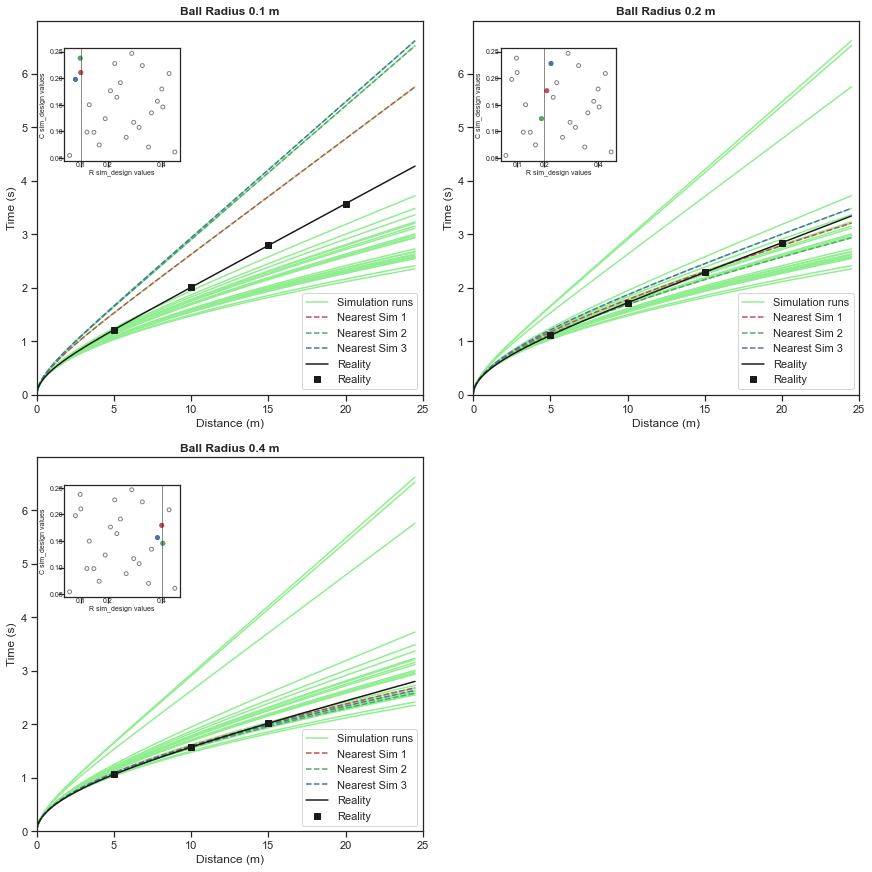

In [6]:
y_obs = list(data_dict['y_field'])
y_obs[-1] = y_obs[-1][0:3]
data_dict['y_field'] = y_obs
R = data_dict['R']             # radii of balls   .1,.2,.4 (m)
h_obs = [np.array([5.,10,15,20]),np.array([5.,10,15,20]),np.array([5.,10,15])]
data_dict['h_field'] = h_obs
plot_data(data_dict)

In [7]:
sim_design = data_dict['sim_design']

R_sim = sim_design[:,0]
C_sim = sim_design[:,1]
h_sim = data_dict['h_sim']
y_sim = data_dict['y_sim']

data = SepiaData(x_sim = np.reshape(R_sim,(len(R_sim),1)),
                 t_sim = np.reshape(C_sim,(len(C_sim),1)), 
                 y_sim = y_sim, y_ind_sim = h_sim,
                 x_obs = R.reshape((len(R),1)), y_obs = y_obs, y_ind_obs=h_obs)

In [8]:
data.transform_xt()
data.standardize_y()

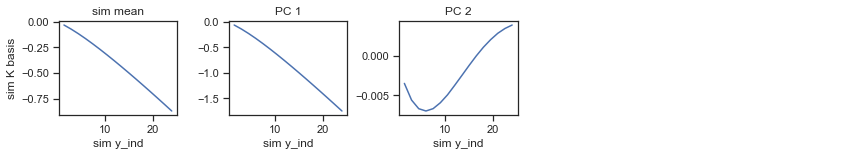

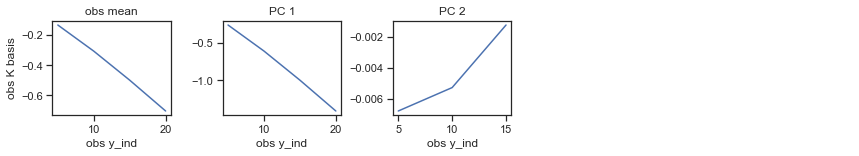

In [9]:
data.create_K_basis(2)
fig_sim, fig_obs = SepiaPlot.plot_K_basis(data)

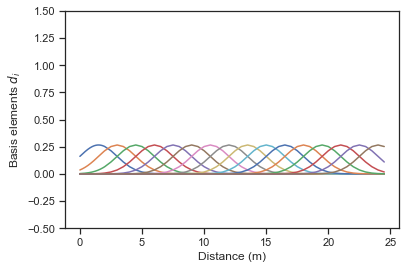

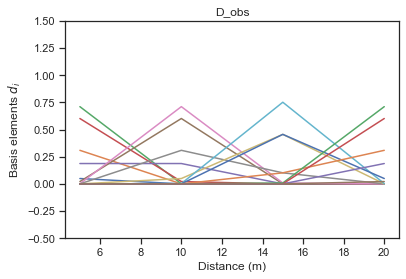

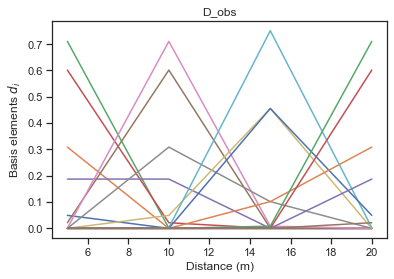

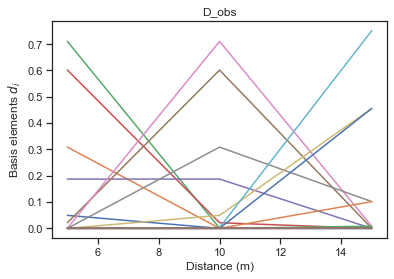

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 16, obs y dimension ragged
n  =     3 (number of observed data)
m  =    25 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     2 (transformed response dimension)
pv =    16 (transformed discrepancy dimension)



In [10]:
# Generate D matrix with normal kernels
D_grid = h_sim # locations on which the kernels are centered
D_width = 1.5  # width of each kernel
pv = len(D_grid)
D_obs = []
D_sim = np.zeros(shape=(data.sim_data.y_ind.shape[0],pv))
h_dense = data_dict['h_dense']
D_dense = np.zeros(shape=(h_dense.shape[0],pv))
for i in range(len(h_obs)):
    tmp = np.zeros(shape=(data.obs_data.y_ind[i].shape[0],pv))
    for j in range(pv):
        tmp[:,j] = norm.pdf(h_obs[i], D_grid[j], D_width) # normal centered at D_grid[j] with sd D_width
    D_obs.append(tmp.T)
    
for j in range(pv):
    D_sim[:,j] = norm.pdf(h_sim, D_grid[j],D_width)
    D_dense[:,j] = norm.pdf(h_dense, D_grid[j],D_width)

data.create_D_basis(D_obs = D_obs, D_sim = D_sim)

plt.ylim(-.5,1.5)
plt.plot(h_dense,D_dense)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$")#;plt.title("D_dense (dense grid)")
plt.show()
plt.ylim(-.5,1.5)
plt.plot(h_obs[0],D_obs[0].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
plt.plot(h_obs[1],D_obs[1].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()
plt.plot(h_obs[2],D_obs[2].T)
plt.xlabel("Distance (m)");plt.ylabel("Basis elements $d_i$");plt.title("D_obs")
plt.show()

print(data)

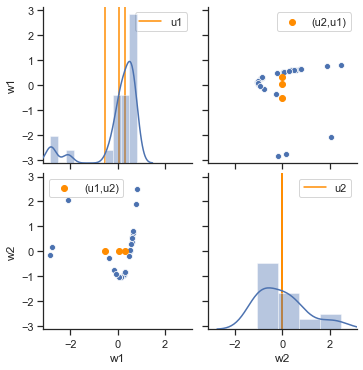

In [11]:
uw_pairs = SepiaPlot.plot_u_w_pairs(data)

In [13]:
model = SepiaModel(data)
nsamp = 1000
#cachefile_name='pkls/ball_drop_1_raggedmodel'
#override = 0
#if os.path.isfile(cachefile_name+'.pkl') and override==0:
#    model.restore_model_info(cachefile_name)
#else:
model.tune_step_sizes(50, 20, update_vals=False)
model.do_mcmc(nsamp)
#model.save_model_info(cachefile_name)

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1]
 [0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5.]]
lamWs
[[100. 100.]]
lamWOs
[[100.]]
lamOs
[[499.99999995]]


MCMC sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.22465943]]
betaV
[[0.23603989]]
betaU
[[0.45677716 1.65077024]
 [0.3977395  2.05685397]]
lamVz
[[151.076012]]
lamUz
[[0.69238083 2.15829461]]
lamWs
[[2433.16507272 4456.45216851]]
lamWOs
[[18142.96622816]]
lamOs
[[45564.64742464]]


MCMC sampling: 100%|██████████| 1000/1000 [00:05<00:00, 192.04it/s]


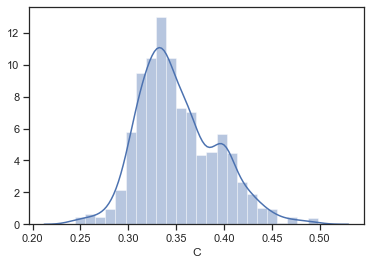

In [14]:
samples_dict = model.get_samples()
theta_names = ['C']
theta_pairs = SepiaPlot.theta_pairs(samples_dict,theta_names)

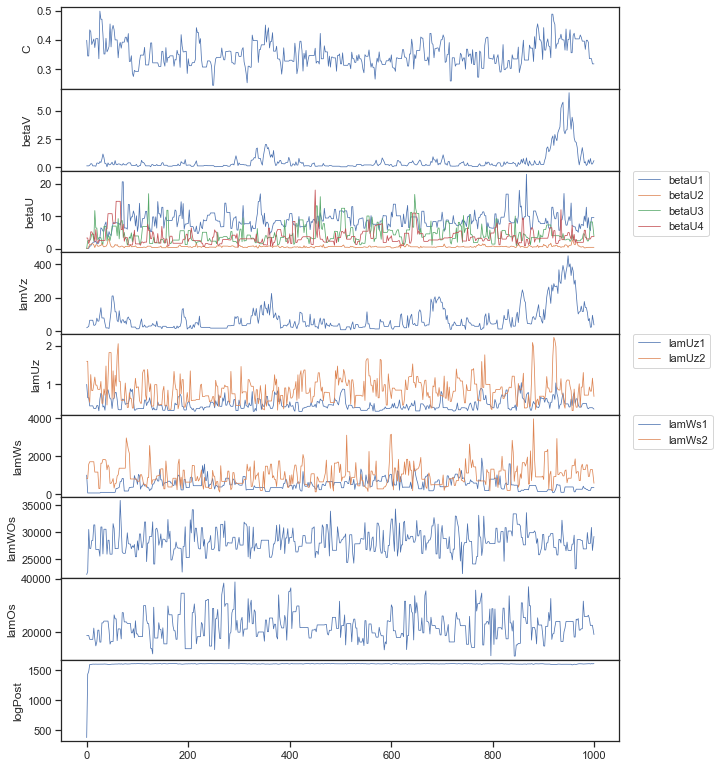

In [15]:
mcmc_trace = SepiaPlot.mcmc_trace(samples_dict,theta_names)

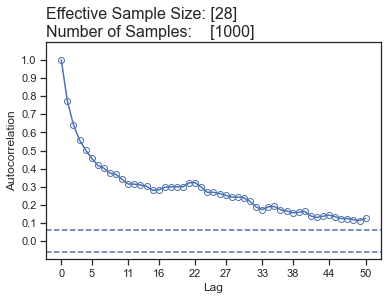

In [16]:
acf = SepiaPlot.plot_acf(model,nlags=50,save='plots/ragged_acf.png')

In [17]:
from sepia.SepiaPredict import SepiaFullPrediction
pred_samples=model.get_samples(nburn=int(.1*nsamp),effectivesamples=True)
pred=SepiaFullPrediction(x_pred=data.obs_data.x, samples=pred_samples, model=model)

Max effective sample size over thetas: 29
Total samples: 1000


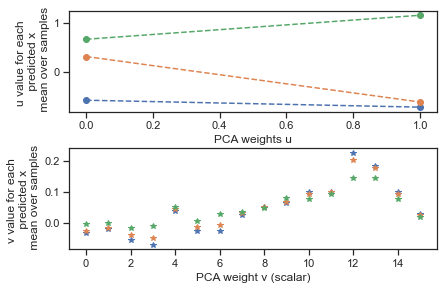

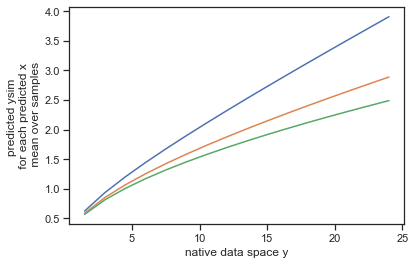

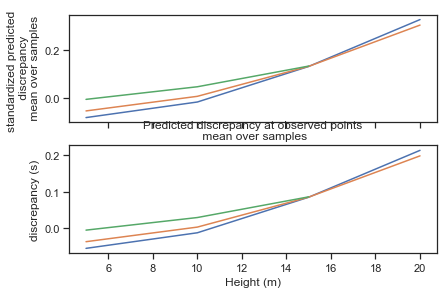

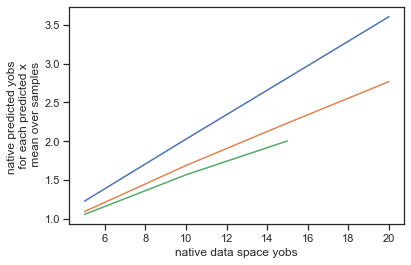

In [18]:
predu, predv = pred.get_u_v()
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.tight_layout()
ax1.plot(np.mean(predu,0).T,'--o')
ax1.set_xlabel('PCA weights u')
ax1.set_ylabel('u value for each \n predicted x \n mean over samples')
ax2.plot(np.mean(predv,0).T,'*')
ax2.set_xlabel('PCA weight v (scalar)')
ax2.set_ylabel('v value for each \n predicted x \n mean over samples')
plt.show()

predysim=pred.get_ysim()
plt.figure()
plt.plot(model.data.sim_data.y_ind,np.mean(predysim,0).T)
plt.xlabel('native data space y')
plt.ylabel('predicted ysim \n for each predicted x \n mean over samples')
plt.show()

preddstd=[]
predd=[]
for i in range(3):
    preddstd.append(pred.get_discrepancy(as_obs=True,std=True,obs_ref=i))
    predd.append(pred.get_discrepancy(as_obs=True,obs_ref=i))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.tight_layout()
for i in range(3):
    ax1.plot(model.data.obs_data.y_ind[i],np.mean(preddstd[i],0).T)
    ax2.plot(model.data.obs_data.y_ind[i],np.mean(predd[i],0).T)  
ax1.set_ylabel('standardized predicted \n discrepancy\n mean over samples')
ax2.set_xlabel('Height (m)')
ax2.set_ylabel('discrepancy (s)')
ax2.set_title('Predicted discrepancy at observed points\n mean over samples')
plt.show()

plt.figure()
for i in range(3):
    plt.plot(model.data.obs_data.y_ind[i],np.mean(pred.get_yobs(as_obs=True,obs_ref=i),0).T)
plt.xlabel('native data space yobs')
plt.ylabel('native predicted yobs \n for each predicted x \n mean over samples')
plt.show()

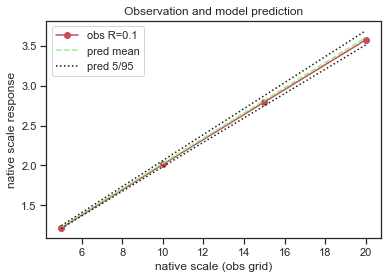

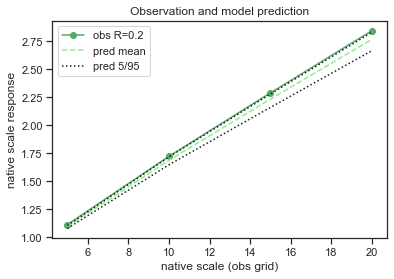

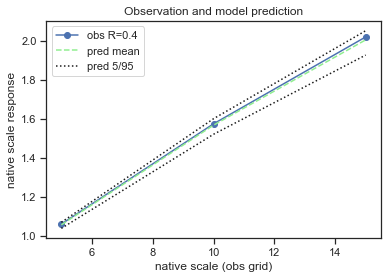

In [19]:
colors = ('r','g','b')
for R_idx in range(3):
    plt.figure()
    predyobs=pred.get_yobs(as_obs=True, std=False, obs_ref=R_idx)
    plt.plot(model.data.obs_data.y_ind[R_idx],model.data.obs_data.y[R_idx],marker='o',c=colors[R_idx])
    plt.plot(model.data.obs_data.y_ind[R_idx],np.mean(predyobs,0).T,'--',c='lightgreen')
    plt.plot(model.data.obs_data.y_ind[R_idx],np.quantile(predyobs,[0.05, 0.95],axis=0).T,'k:')
    plt.xlabel('native scale (obs grid)')
    plt.ylabel('native scale response')
    plt.title('Observation and model prediction')
    plt.legend(['obs R={}'.format(R[R_idx]),'pred mean','pred 5/95'])
    plt.show()